### Primer 2 - Dot space

* Sliku **cyrilic_train.jpg** koristiti za obučavanje veštačke neuronske mreže
* Nakon obučavanja, na slici **cyrilic_test.jpg** pročitati tekst.
Autoru ovog teksta se pokvarilo "space" dugme, pa je koristio ".." za razmak između reči, tok je za razmak između slova koristio ".".


In [2]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
#from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = erode(dilate(erode(erode(binary_image))))
    return ret_val


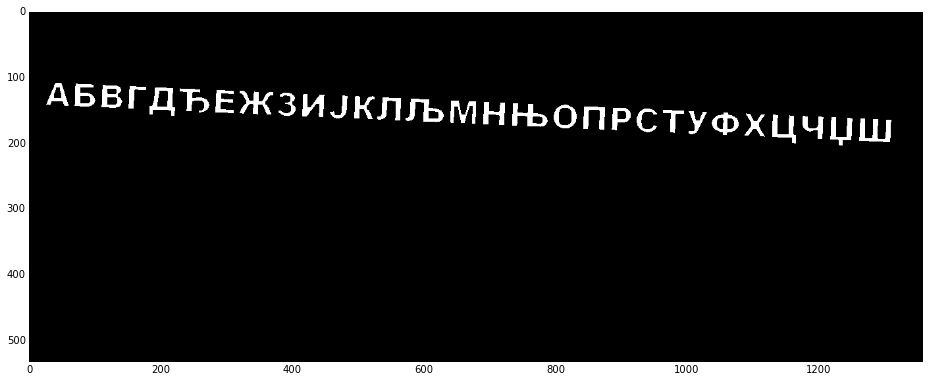

In [3]:
#otklanjanje suma
img_train = load_image('cyrilic_train.jpg')
img_train_bin = remove_noise(image_bin(image_gray(img_train)))
display_image(img_train_bin)


In [4]:
def rotate_regions(contours,angles,centers,sizes):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

In [11]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,w,h = cv2.boundingRect(contour)
        
        region_points = []
        for i in range (xt,xt+w):
            for j in range(yt,yt+h):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        cv2.rectangle(image_orig,(xt,yt),(xt+w,yt+h),(0,255,0),2)
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
    
    #Postavljanje kontura u vertikalan polozaj
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes)
    
    min_area_set = False
    min_area = 0
    max_area = 0
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])
        
        w = max_x - min_x
        h = max_y - min_y
        area = w*h
        
        if ((not min_area_set) or (min_area > area)):
            min_area_set = True
            min_area = area
        
        if (max_area < area):
            max_area = area
        
        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    dots = []
    
    if (min_area < max_area/3):
        indexes = []
        for elem in sorted_regions:
            x,y,w,h = elem[1]
            if (w*h > min_area * 0.5 and w*h < min_area * 1.5):
                indexes.append(len(dots))
                dots.append(1)
            else:
                dots.append(0)


        sorted_regions = np.delete(sorted_regions, indexes, axis = 0)
    else:
        dots = [0 for elem in sorted_regions]
    return image_orig, sorted_regions[:, 0], dots

In [12]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=29,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

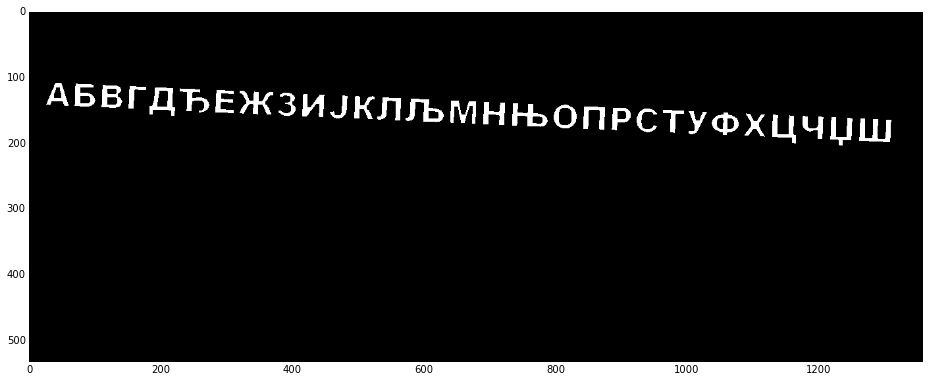

In [13]:
img_train = load_image('cyrilic_train.jpg')
img_train_bin = remove_noise(image_bin(image_gray(img_train)))
sel_img_train, shapes, dots = select_roi(img_train.copy(), img_train_bin)
display_image(img_train_bin)
inputs = prepare_for_ann(shapes)
alphabet = ['А','Б','В','Г','Д','Ђ','Е','Ж','З','И','Ј','К','Л','Љ','М','Н','Њ','О','П','Р','С','Т','У','Ф','Х','Ц','Ч','Џ','Ш']
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [14]:
def display_result(outputs, alphabet, dots):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    output_index = 0
    result = ""
    for idx, dot in enumerate(dots):
        if (dot == 0):
            elem = alphabet[winner(outputs[output_index, :])]
            result += elem
            output_index += 1
        elif (dots[idx - 1] == 1):
            result += " "
            
    return result

In [15]:

results = ann.predict(np.array(inputs, np.float32))
print display_result(results, alphabet, dots)

АБВГДЂЕЖЗИЈКЛЉМНЊОПРСТУФХЦЧЏШ


СОФТ КОЛОКВИЈУМ ПРИМЕР


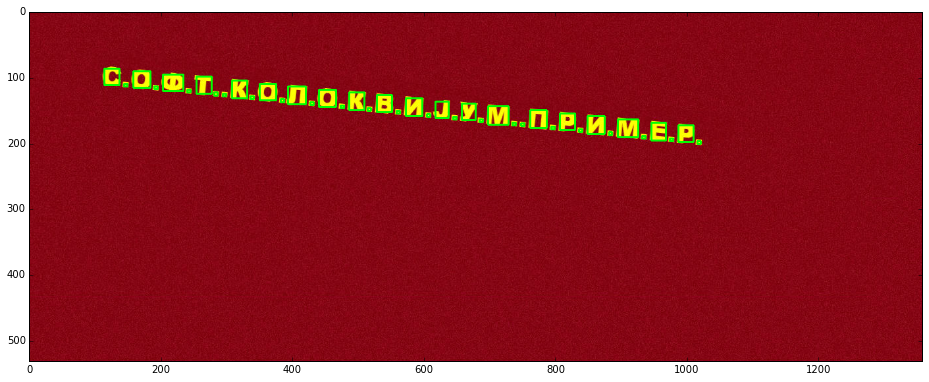

In [16]:
img_test = load_image('cyrilic_test.jpg')
img_test_bin = remove_noise(image_bin(image_gray(img_test)))
sel_img_test, shapes, dots = select_roi(img_test.copy(), img_test_bin)
display_image(sel_img_test)
inputs = prepare_for_ann(shapes)
results = ann.predict(np.array(inputs, np.float32))
print display_result(results, alphabet, dots)